In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from scipy.optimize import minimize
from scipy import stats
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.feature_selection import RFECV
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
SEED = 42
n_splits = 10
optimize_params = False
optimize_features = False
n_trials = 25 # n_trials for optuna 
min_features_to_select = 100 # min features to select with RFECV
base_thresholds = [30, 50, 80]

# Load datasets
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [3]:
def time_features(df):
    # Convert time_of_day to hours
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    # Define conditions for night, day, and no mask (full data)
    night = ((df["hours"] >= 22) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 7))
    no_mask = np.ones(len(df), dtype=bool)
    # Define weekend and last week conditions
    weekend = (df["weekday"] >= 6)
    last_week = df["relative_date_PCIAT"] >= (df["relative_date_PCIAT"].max() - 7)
    # Create additional weekend features
    df["enmo_weekend"] = df["enmo"].where(weekend)
    df["anglez_weekend"] = df["anglez"].where(weekend)
    # Basic features 
    features = [
        df["non-wear_flag"].mean(),
        df["battery_voltage"].mean(),
        df["battery_voltage"].diff().mean(),
        df["relative_date_PCIAT"].tail(1).values[0]
    ]
    
    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "enmo_weekend", "anglez_weekend"]
    masks = [no_mask, night, day, last_week]
    
    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(), 
            data.std(), 
            data.max(), 
            data.min(), 
            data.kurtosis(), 
            data.skew(), 
            data.diff().mean(), 
            data.diff().std(), 
            data.diff().quantile(0.9), 
            data.diff().quantile(0.1)
        ]
    
    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

# Code for parallelized computation of time series data from: Sheikh Muhammad Abdullah 
# https://www.kaggle.com/code/abdmental01/cmi-best-single-model
def process_file(filename, dirname):
    # Process file and extract time features
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return time_features(df), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    # Load time series from directory in parallel
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [4]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

train = train[train["sii"].notna()] # Keep rows where target is available
train.shape

100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


(2736, 285)

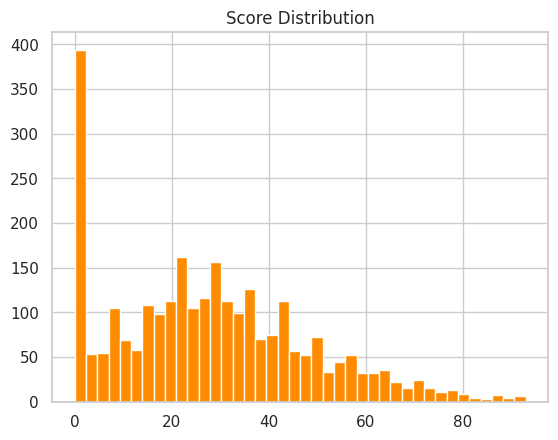

In [5]:
# Plot distribution of total scores which determine the sii
# Note the excess zeros
sns.set_theme(style="whitegrid")
plt.hist(train['PCIAT-PCIAT_Total'], bins=40, color="darkorange")
plt.title('Score Distribution')
plt.show()

In [6]:
# Features to exclude, because they're not in test
exclude = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']

y = "PCIAT-PCIAT_Total" # Score, target for the model
target = "sii" # Index, target of the competition
features = [f for f in train.columns if f not in exclude]

# Categorical features
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

# Mapping of categorical columns from: Sheikh Muhammad Abdullah 
# https://www.kaggle.com/code/abdmental01/cmi-best-single-model
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

# Simple mean imputation
for f in features:
    f_mean = np.mean(train[f])
    train.loc[:, f] = train[f].fillna(f_mean)
    test.loc[:, f] = test[f].fillna(f_mean)

In [7]:
# Code for finding optimal thresholds copied from: Michael Semenoff
# https://www.kaggle.com/code/michaelsemenoff/cmi-actigraphy-feature-engineering-selection
def round_with_thresholds(raw_preds, thresholds):
    return np.where(raw_preds < thresholds[0], int(0),
                    np.where(raw_preds < thresholds[1], int(1),
                             np.where(raw_preds < thresholds[2], int(2), int(3))))

def optimize_thresholds(y_true, raw_preds, start_vals=[0.5, 1.5, 2.5]):
    def fun(thresholds, y_true, raw_preds):
        rounded_preds = round_with_thresholds(raw_preds, thresholds)
        return -cohen_kappa_score(y_true, rounded_preds, weights='quadratic')

    res = minimize(fun, x0=start_vals, args=(y_true, raw_preds), method='Nelder-Mead')
    assert res.success
    return res.x

In [8]:
def cross_validate(model_, data, features, score_col, index_col, cv, verbose=False):
    """
    Perform cross-validation with a given model and compute the out-of-fold 
    predictions and Cohen's Kappa score for each fold.

    Returns:
    float: Mean Kappa score across all folds.
    array: Out-of-fold score predictions for the entire dataset.
    """
    kappa_scores = [] 
    oof_score_predictions = np.zeros(len(data))  

    score_to_index_thresholds = base_thresholds  

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(data, data[index_col])):
        # Split data into training and validation sets
        X_train, X_val = data[features].iloc[train_idx], data[features].iloc[val_idx]
        y_train_score = data[score_col].iloc[train_idx]  
        y_val_score = data[score_col].iloc[val_idx]      
        y_val_index = data[index_col].iloc[val_idx]     
        
        # Train model and predict scores for validation set
        model_.fit(X_train, y_train_score)
        y_pred_val_score = model_.predict(X_val)
        
        oof_score_predictions[val_idx] = y_pred_val_score  # Store OOF predictions

        # Convert predicted scores to index using thresholds
        y_pred_val_index = round_with_thresholds(y_pred_val_score, score_to_index_thresholds)

        # Calculate Kappa score for the fold
        kappa_score = cohen_kappa_score(y_val_index, y_pred_val_index, weights='quadratic')
        kappa_scores.append(kappa_score)
        
        if verbose:
            print(f"Fold {fold_idx}: Kappa Score = {kappa_score}")
    
    if verbose:
        print(f"Mean CV Kappa Score: {np.mean(kappa_scores)}")
    
    return np.mean(kappa_scores), oof_score_predictions

In [9]:
def objective(trial, model_type, X, features, score_col, index_col, cv):
    # Parameter space to explore if model is xgboost
    if model_type == 'xgboost':
        params = {
            'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'reg:tweedie', 'reg:pseudohubererror']),
            'random_state': SEED,
            'n_estimators': trial.suggest_int('n_estimators', 300, 800),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.02, 0.1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e-1),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e-1)
        }
        if params['objective'] == 'reg:tweedie':
            params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1, 2)
        model = XGBRegressor(**params, use_label_encoder=False)
    
    # Parameter space to explore if model is lightgbm
    elif model_type == 'lightgbm':
        params = {
            'objective': trial.suggest_categorical('objective', ['poisson', 'tweedie', 'quantile', 'regression']),
            'random_state': SEED,
            'verbosity': -1,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        if params['objective'] == 'tweedie':
            params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1, 2)
        model = LGBMRegressor(**params)
    
    # Parameter space to explore if model is catboost
    elif model_type == 'catboost':
        params = {
            'loss_function': trial.suggest_categorical('objective', ['Tweedie:variance_power=1.5', 'Quantile', 'Poisson', 'RMSE']),
            'random_state': SEED,
            'iterations': trial.suggest_int('iterations', 200, 700),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e-1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0)
        }
        model = CatBoostRegressor(**params, verbose=0)
    
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

    score, _ = cross_validate(model, X, features, score_col, index_col, cv)

    return score

def run_optimization(X, features, score_col, index_col, model_type, n_trials=30, cv=None):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, model_type, X, features, score_col, index_col, cv), 
                   n_trials=n_trials)
    
    print(f"Best params for {model_type}: {study.best_params}")
    print(f"Best score: {study.best_value}")
    return study.best_params
def custom_kappa_scorer(y_true, y_pred):
    y_pred = round_with_thresholds(y_pred, base_thresholds)
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def perform_rfecv(model, X, y, cv, step=1, scoring='neg_mean_squared_error', min_features_to_select=30, n_jobs=-1, verbose=0):
    """
    Perform Recursive Feature Elimination with Cross-Validation (RFECV) to select optimal features.
    
    Returns:
    list: Names of the optimal features selected by RFECV.
    """
    rfecv = RFECV(
        estimator=model,
        step=step,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        min_features_to_select=min_features_to_select,
        verbose=verbose
    )
    # Fit the RFECV model and perform feature elimination
    rfecv.fit(X, y)
    
    # Extract optimal features based on ranking
    optimal_features = [feature for feature, rank in zip(X.columns, rfecv.ranking_) if rank == 1]
    
    # Output results
    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Selected features: {optimal_features}")
    
    return optimal_features

In [10]:
lgb_features = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_GSND', 
                'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 
                'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 
                'BIA-BIA_TBW', 'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-Season', 
                'PreInt_EduHx-computerinternet_hoursday', 'stat_1', 'stat_3', 'stat_4', 'stat_18', 'stat_19', 'stat_20', 'stat_30', 'stat_39', 'stat_41', 'stat_42',
                'stat_44', 'stat_57', 'stat_64', 'stat_72', 'stat_75', 'stat_76', 'stat_84', 'stat_98', 'stat_102', 'stat_104', 'stat_106', 'stat_116', 'stat_118', 
                'stat_121', 'stat_134', 'stat_136', 'stat_141', 'stat_146', 'stat_149', 'stat_174', 'stat_176', 'stat_184', 'stat_187', 'stat_189', 'stat_192', 
                'stat_196', 'stat_200']
xgb_features = ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 
                'Physical-Waist_Circumference', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 
                'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'stat_1', 'stat_3', 
                'stat_4', 'stat_18', 'stat_19', 'stat_20', 'stat_24', 'stat_25', 'stat_28', 'stat_30', 'stat_31', 'stat_33', 'stat_34', 'stat_35', 'stat_38',
                'stat_39', 'stat_40', 'stat_41', 'stat_44', 'stat_55', 'stat_57', 'stat_58', 'stat_59', 'stat_64', 'stat_65', 'stat_67', 'stat_68', 'stat_69',
                'stat_70', 'stat_71', 'stat_72', 'stat_73', 'stat_74', 'stat_75', 'stat_76', 'stat_80', 'stat_83', 'stat_96', 'stat_98', 'stat_99', 'stat_100',
                'stat_102', 'stat_103', 'stat_104', 'stat_105', 'stat_106', 'stat_110', 'stat_111', 'stat_112', 'stat_116', 'stat_118', 'stat_119', 'stat_121',
                'stat_123', 'stat_134', 'stat_141', 'stat_142', 'stat_144', 'stat_146', 'stat_149', 'stat_151', 'stat_152', 'stat_154', 'stat_156', 'stat_159',
                'stat_161', 'stat_164', 'stat_174', 'stat_176', 'stat_179', 'stat_180', 'stat_183', 'stat_186', 'stat_188', 'stat_189', 'stat_190', 'stat_191',
                'stat_192', 'stat_193', 'stat_196', 'stat_197', 'stat_198', 'stat_201']
cat_features = ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 
                'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 
                'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_TL', 
                'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Season', 
                'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 
                'PreInt_EduHx-computerinternet_hoursday', 'stat_1', 'stat_2', 'stat_3', 'stat_19', 'stat_20', 'stat_21', 'stat_30', 'stat_31', 'stat_33', 
                'stat_34', 'stat_36', 'stat_39', 'stat_40', 'stat_41', 'stat_42', 'stat_43', 'stat_44', 'stat_47', 'stat_54', 'stat_56', 'stat_57', 'stat_60',
                'stat_62', 'stat_65', 'stat_67', 'stat_68', 'stat_70', 'stat_72', 'stat_73', 'stat_74', 'stat_75', 'stat_76', 'stat_77', 'stat_78', 'stat_80',
                'stat_84', 'stat_96', 'stat_98', 'stat_100', 'stat_102', 'stat_103', 'stat_104', 'stat_105', 'stat_106', 'stat_109', 'stat_110', 'stat_115',
                'stat_116', 'stat_121', 'stat_123', 'stat_127', 'stat_134', 'stat_139', 'stat_140', 'stat_142', 'stat_144', 'stat_146', 'stat_149', 'stat_150',
                'stat_151', 'stat_154', 'stat_159', 'stat_161', 'stat_164', 'stat_167', 'stat_174', 'stat_176', 'stat_181', 'stat_184', 'stat_185', 'stat_186',
                'stat_189', 'stat_190', 'stat_191', 'stat_192', 'stat_193', 'stat_197', 'stat_200']

In [11]:
# Parameters for LGBM, XGB and CatBoost
lgb_params = {
    'objective': 'regression', 
    'n_estimators': 165, 
    'max_depth': 12, 
    'learning_rate': 0.046, 
    'subsample': 0.6734915155561385, 
    'colsample_bytree': 0.5263197975884975
}

xgb_params = {
    'objective': 'reg:squarederror', 
    'n_estimators': 478, 
    'max_depth': 6, 
    'learning_rate': 0.03416918255604553, 
    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    'gamma': 1.3368387307987768, 
    'reg_alpha': 1, 
    'reg_lambda': 5
}

cat_params = {
    'objective': 'RMSE', 
    'iterations': 200, 
    'depth': 6, 
    'learning_rate': 0.05, 
    'l2_leaf_reg': 10, 
    'subsample': 0.5002380405809761
}






In [12]:
kappa_scorer = make_scorer(custom_kappa_scorer, greater_is_better=True)
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

if optimize_features:
    # LightGBM Feature Selection
    lgb_model = LGBMRegressor(**lgb_params, random_state=SEED, verbosity=0)
    lgb_features = perform_rfecv(
        model=lgb_model,
        X=train[lgb_features],
        y=train['PCIAT-PCIAT_Total'],
        cv=kf,
        scoring=kappa_scorer,
        min_features_to_select=min_features_to_select,
        verbose=1
    )

    # XGBoost Feature Selection
    xgb_model = XGBRegressor(**xgb_params, random_state=SEED, verbose=0, tree_method = "hist")
    xgb_features = perform_rfecv(
        model=xgb_model,
        X=train[xgb_features],
        y=train['PCIAT-PCIAT_Total'],
        cv=kf,
        scoring=kappa_scorer,
        min_features_to_select=min_features_to_select,
        verbose=1
    )

    # CatBoost Feature Selection
    cat_model = CatBoostRegressor(**cat_params, random_state=SEED, verbose=0)
    cat_features = perform_rfecv(
        model=cat_model,
        X=train[cat_features],
        y=train['PCIAT-PCIAT_Total'],
        cv=kf,
        scoring=kappa_scorer,
        min_features_to_select=min_features_to_select,
        verbose=1
    )

if optimize_params:
    # LightGBM Optimization
    lgb_params = run_optimization(train, lgb_features, 'PCIAT-PCIAT_Total', 'sii', 'lightgbm', n_trials=n_trials, cv=kf)

    # XGBoost Optimization
    xgb_params = run_optimization(train, xgb_features, 'PCIAT-PCIAT_Total', 'sii', 'xgboost', n_trials=n_trials, cv=kf)

    # CatBoost Optimization
    cat_params = run_optimization(train, cat_features, 'PCIAT-PCIAT_Total', 'sii', 'catboost', n_trials=n_trials, cv=kf)

In [13]:
# Define models
lgb_model = LGBMRegressor(**lgb_params, random_state=SEED, verbosity=-1)
xgb_model = XGBRegressor(**xgb_params, random_state=SEED, verbosity=0)
cat_model = CatBoostRegressor(**cat_params, random_state=SEED, verbose=0)

# Cross-validate LGBM model
score_lgb, oof_lgb = cross_validate(lgb_model, train, lgb_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True)
lgb_model.fit(train[lgb_features], train['PCIAT-PCIAT_Total'])
test_lgb = lgb_model.predict(test[lgb_features])

# Cross-validate XGBoost model
score_xgb, oof_xgb = cross_validate(xgb_model, train, xgb_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True)
xgb_model.fit(train[xgb_features], train['PCIAT-PCIAT_Total'])
test_xgb = xgb_model.predict(test[xgb_features])

# Cross-validate CatBoost model
score_cat, oof_cat = cross_validate(cat_model, train, cat_features, 'PCIAT-PCIAT_Total', 'sii', kf, verbose=True)
cat_model.fit(train[cat_features], train['PCIAT-PCIAT_Total'])
test_cat = cat_model.predict(test[cat_features])

Fold 0: Kappa Score = 0.4162094415819524
Fold 1: Kappa Score = 0.49245937983139343
Fold 2: Kappa Score = 0.44606708695767827
Fold 3: Kappa Score = 0.49062215979509216
Fold 4: Kappa Score = 0.39020198890047053
Fold 5: Kappa Score = 0.45747178457273785
Fold 6: Kappa Score = 0.36857247623614353
Fold 7: Kappa Score = 0.32214011232633744
Fold 8: Kappa Score = 0.3947667804323094
Fold 9: Kappa Score = 0.39058823529411757
Mean CV Kappa Score: 0.4169099445928233
Fold 0: Kappa Score = 0.47008667664247994
Fold 1: Kappa Score = 0.45324298716586753
Fold 2: Kappa Score = 0.44772080173653206
Fold 3: Kappa Score = 0.45688042658924033
Fold 4: Kappa Score = 0.3869320521619767
Fold 5: Kappa Score = 0.4475342350667898
Fold 6: Kappa Score = 0.38844779674473995
Fold 7: Kappa Score = 0.36157726757953257
Fold 8: Kappa Score = 0.39601769911504425
Fold 9: Kappa Score = 0.39446366782006925
Mean CV Kappa Score: 0.42029036106222717
Fold 0: Kappa Score = 0.36243720528862444
Fold 1: Kappa Score = 0.42504755291204976

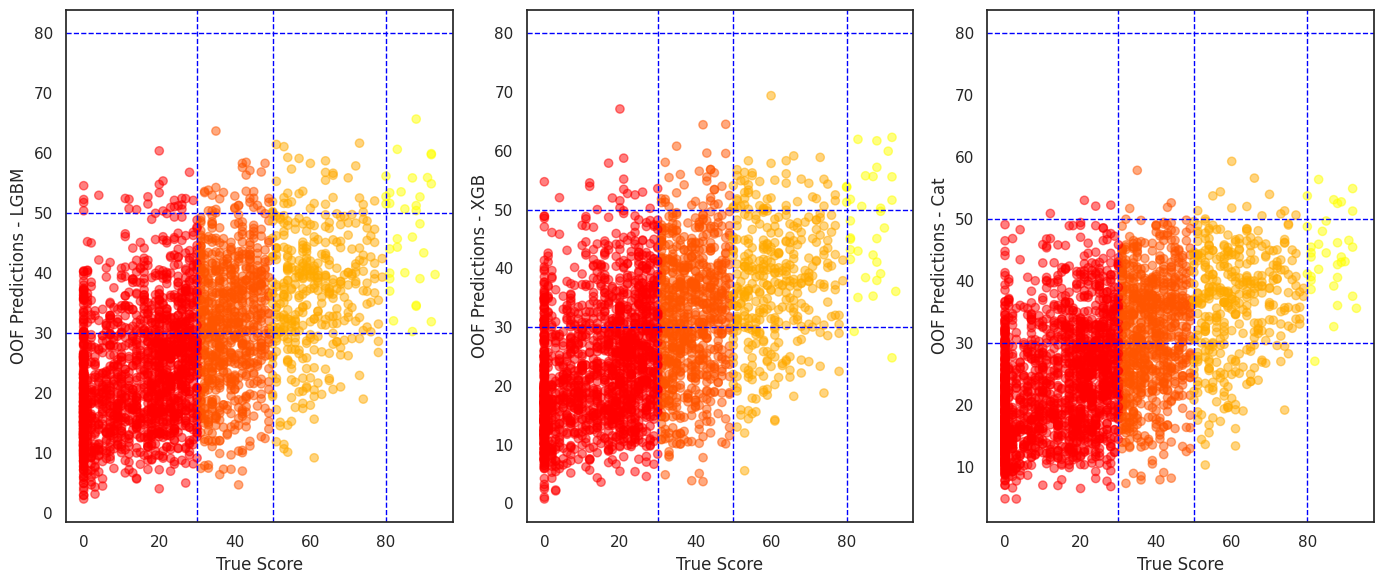

In [14]:
# Plot predicted scores against true scores with the base thresholds for converting score to sii
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

scatter1 = axes[0].scatter(train['PCIAT-PCIAT_Total'], oof_lgb, c=train["sii"], cmap="autumn", alpha=0.5)
axes[0].set_xlabel("True Score")
axes[0].set_ylabel("OOF Predictions - LGBM")

thresholds = [30, 50, 80]
for threshold in thresholds:
    axes[0].axhline(threshold, color="blue", linestyle="--", lw=1)
    axes[0].axvline(threshold, color="blue", linestyle="--", lw=1)

scatter2 = axes[1].scatter(train['PCIAT-PCIAT_Total'], oof_xgb, c=train["sii"], cmap="autumn", alpha=0.5)
axes[1].set_xlabel("True Score")
axes[1].set_ylabel("OOF Predictions - XGB")

for threshold in thresholds:
    axes[1].axhline(threshold, color="blue", linestyle="--", lw=1)
    axes[1].axvline(threshold, color="blue", linestyle="--", lw=1)
    
scatter3 = axes[2].scatter(train['PCIAT-PCIAT_Total'], oof_cat, c=train["sii"], cmap="autumn", alpha=0.5)
axes[2].set_xlabel("True Score")
axes[2].set_ylabel("OOF Predictions - Cat")

for threshold in thresholds:
    axes[2].axhline(threshold, color="blue", linestyle="--", lw=1)
    axes[2].axvline(threshold, color="blue", linestyle="--", lw=1)

plt.tight_layout()
plt.show()

LGBM optimized thresholds: [30.13604141 37.27867134 89.7825534 ]
XGBoost optimized thresholds: [28.64630108 38.73586735 92.75440972]
CatBoost optimized thresholds: [33.66643963 37.53679148 83.96712476]
Voted ensemble Kappa score: 0.46152002659389424


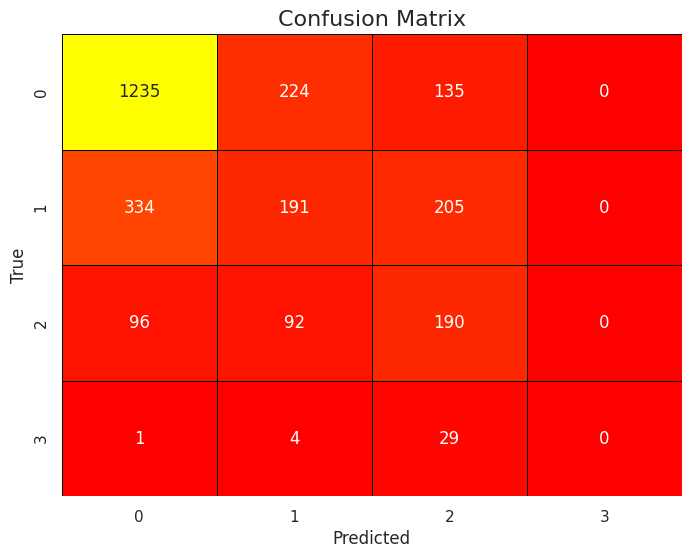

In [15]:
# Optimize thresholds for each model's OOF predictions
lgb_thresholds = optimize_thresholds(train["sii"], oof_lgb, start_vals=base_thresholds)
print(f"LGBM optimized thresholds: {lgb_thresholds}")

xgb_thresholds = optimize_thresholds(train["sii"], oof_xgb, start_vals=base_thresholds)
print(f"XGBoost optimized thresholds: {xgb_thresholds}")

cat_thresholds = optimize_thresholds(train["sii"], oof_cat, start_vals=base_thresholds)
print(f"CatBoost optimized thresholds: {cat_thresholds}")

# Apply the optimized thresholds to OOF predictions
oof_lgb = round_with_thresholds(oof_lgb, lgb_thresholds)
oof_xgb = round_with_thresholds(oof_xgb, xgb_thresholds)
oof_cat = round_with_thresholds(oof_cat, cat_thresholds)
voted_oof = stats.mode(np.array([oof_lgb, oof_xgb, oof_cat]), axis=0).mode.flatten().astype(int)

# Calculate Kappa score for voted OOF predictions
kappa_score = cohen_kappa_score(train["sii"], voted_oof, weights='quadratic')
print(f"Voted ensemble Kappa score: {kappa_score}")
# Plot confusion matrix
conf_matrix = confusion_matrix(train["sii"], voted_oof)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="autumn", cbar=False, linewidths=0.5, linecolor='black')
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()



In [16]:
# Apply the optimized thresholds to test predictions
test_lgb = round_with_thresholds(test_lgb, lgb_thresholds)
test_xgb = round_with_thresholds(test_xgb, xgb_thresholds)
test_cat = round_with_thresholds(test_cat, cat_thresholds)
voted_test = stats.mode(np.array([test_lgb, test_xgb, test_cat]), axis=0).mode.flatten().astype(int)

submission = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")
submission['sii'] = voted_test
submission.to_csv("submission.csv", index=False)